# Softmax exercise
Victoria Yong 1004455

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission.*

In this exercise, you will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


**Acknowledgement: This exercise is adapted from [Stanford CS231n](http://cs231n.stanford.edu/).**

In [1]:
import random
import numpy as np
from data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def rel_error(out, correct_out):
    return np.sum(abs(out - correct_out) / (abs(out) + abs(correct_out)))

In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    Softmax, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    # # We will also make a development set, which is a small subset of
    # the training set.
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]

    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image

    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


In [4]:
# Create one-hot vectors for label
num_class = 10
y_train_oh = np.zeros((y_train.shape[0], 10))
y_train_oh[np.arange(y_train.shape[0]), y_train] = 1
y_val_oh = np.zeros((y_val.shape[0], 10))
y_val_oh[np.arange(y_val.shape[0]), y_val] = 1
y_test_oh = np.zeros((y_test.shape[0], 10))
y_test_oh[np.arange(y_test.shape[0]), y_test] = 1

y_dev_oh = np.zeros((y_dev.shape[0], 10))
y_dev_oh[np.arange(y_dev.shape[0]), y_dev] = 1

# Regression as classifier
The most simple and straightforward approach to learn a classifier is to map the input data (raw image values) to class label (one-hot vector). The loss function is defined as following: 
$$\mathcal{L}=\frac{1}{n}\|\mathbf{X}\mathbf{W}-\mathbf{y}\|_F^2\qquad\qquad(1)$$
Where:
* $\mathbf{W}\in \mathbb{R}^{(d+1)\times C}$: Classifier weight
* $\mathbf{X}\in \mathbb{R}^{n\times (d+1)}$: Dataset
* $\mathbf{y}\in \mathbb{R}^{n\times C}$: Class label (one-hot vector)

# Optimization
Given the loss function (1), the next problem is how to solve the weight $\mathbf{W}$. We now discuss 2 approaches: 
 * Random search
 * Closed-form solution

## Random search

In [5]:
bestloss = float('inf')
for num in range(100):
    W = np.random.randn(3073, 10) * 0.0001
    loss = np.linalg.norm(X_dev.dot(W) - y_dev_oh)
    if (loss < bestloss):
        bestloss = loss
        bestW = W
    print('in attempt %d the loss was %f, best %f' % (num, loss, bestloss))

in attempt 0 the loss was 35.486501, best 35.486501
in attempt 1 the loss was 33.961882, best 33.961882
in attempt 2 the loss was 32.852503, best 32.852503
in attempt 3 the loss was 31.354537, best 31.354537
in attempt 4 the loss was 32.947541, best 31.354537
in attempt 5 the loss was 33.607856, best 31.354537
in attempt 6 the loss was 37.786107, best 31.354537
in attempt 7 the loss was 35.832182, best 31.354537
in attempt 8 the loss was 32.177872, best 31.354537
in attempt 9 the loss was 34.115906, best 31.354537
in attempt 10 the loss was 32.274524, best 31.354537
in attempt 11 the loss was 33.060083, best 31.354537
in attempt 12 the loss was 32.197298, best 31.354537
in attempt 13 the loss was 32.065728, best 31.354537
in attempt 14 the loss was 31.279332, best 31.279332
in attempt 15 the loss was 37.748851, best 31.279332
in attempt 16 the loss was 34.616167, best 31.279332
in attempt 17 the loss was 31.946376, best 31.279332
in attempt 18 the loss was 32.191993, best 31.279332
in 

In [6]:
# How bestW perform:
print('Accuracy on train set: ', np.sum(np.argmin(np.abs(1 - X_dev.dot(W)), axis=1) == y_dev).astype(np.float32)/y_dev.shape[0]*100)
print('Accuracy on test set: ', np.sum(np.argmin(np.abs(1 - X_test.dot(W)), axis=1) == y_test).astype(np.float32)/y_test.shape[0]*100)

Accuracy on train set:  8.799999999999999
Accuracy on test set:  10.9


You can clearly see that the performance is very low, almost at the random level.

## Closed-form solution
The closed-form solution is achieved by:
$$\frac{\partial\mathcal{L}}{\partial \mathbf{W}}=\frac{2}{n}\mathbf{X}^T(\mathbf{X}\mathbf{W}-\mathbf{y})=0$$

$$\Leftrightarrow\mathbf{W}^\ast=(\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}$$

In [7]:
################################################################################
# TODO:                                                                        #
# Implement the closed-form solution of the weight W.                          #
################################################################################
W = np.linalg.pinv(X_train.T@X_train) @ (X_train.T@y_train_oh)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

In [8]:
# Check accuracy:
print('Train set accuracy: ', np.sum(np.argmin(np.abs(1 - X_train.dot(W)), axis=1) == y_train).astype(np.float32)/y_train.shape[0]*100)
print('Test set accuracy: ', np.sum(np.argmin(np.abs(1 - X_test.dot(W)), axis=1) == y_test).astype(np.float32)/y_test.shape[0]*100)

Train set accuracy:  51.163265306122454
Test set accuracy:  36.199999999999996


Now, you can see that the performance is much better.

## Regularization
A simple way to improve performance is to include the L2-regularization penalty.
$$\mathcal{L}=\frac{1}{n}\|\mathbf{X}\mathbf{W}-\mathbf{y}\|_F^2 +\lambda \|\mathbf{W}\|_F^2 \qquad\qquad(2)$$
The closed-form solution now is: 
$$\Leftrightarrow\mathbf{W}^\ast=(\mathbf{X}^T\mathbf{X}+\lambda n\mathbf{I})^{-1}\mathbf{X}^T\mathbf{y}$$

In [9]:
# try several values of lambda to see how it helps:
lambdas = [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
train_acc = np.zeros((len(lambdas)))
test_acc = np.zeros((len(lambdas)))
for i in range(len(lambdas)):
    l = lambdas[i]
    n,d = X_train.shape[0], X_train.shape[1]
    ################################################################################
    # TODO:                                                                        #
    # Implement the closed-form solution of the weight W with regularization.      #
    ################################################################################
    I = np.eye(d)
    W = np.linalg.pinv(X_train.T@X_train + l*n*I) @ (X_train.T@y_train_oh)
    ################################################################################
    #                              END OF YOUR CODE                                #
    ################################################################################
    train_acc[i] = np.sum(np.argmin(np.abs(1 - X_train.dot(W)), axis=1) == y_train).astype(np.float32)/y_train.shape[0]*100
    test_acc[i]  = np.sum(np.argmin(np.abs(1 - X_test.dot(W)), axis=1) == y_test).astype(np.float32)/y_test.shape[0]*100

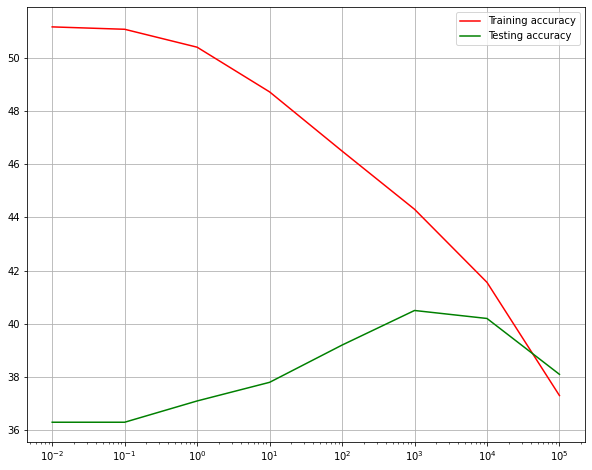

In [10]:
plt.semilogx(lambdas, train_acc, 'r', label="Training accuracy")
plt.semilogx(lambdas, test_acc, 'g', label="Testing accuracy")

plt.legend()
plt.grid(True)
plt.show()

**Question:** Try to explain why the performances on the training and test set have such behaviors as we change the value of $\lambda$.

**Your answer:** lambda is the regularization term which penelizes the loss to prevent overfitting of the model. As lambda increases, the severity of the penalty increases, which minimizes the weights and thus reduces its impact on the resulting prediction. With a small lambda, the model's accuracy on the training set is much higher than the test set, which indicates overfitting. The model is unable to generalize well. As lambda increases, weights are penalized more and the model's ability to generalize improves. This is reflected by its accuracy on the test set increasing up until lambda 10^3. Naturally, it's accuracy on the training set reduces as a result. As lambda continues to increase, accuracy starts to drop, and at lambda values greater than 10^4, the model's accuracy drops drastically on both test and training sets, indicating underfitting.

## Softmax Classifier

The predicted probability for the $j$-th class given a sample vector $x$ and a weight $W$ is:

$$\displaystyle{P(y=j\mid x)=\frac{e^{-xw_j}}{\sum\limits_{c=1}^{C}e^{-xw_c}}}$$ 

![softmax](imgs/softmax.png "Example of Softmax")

Your code for this section will all be written inside **classifiers/softmax.py**. 


In [11]:
# First implement the naive softmax loss function with nested loops.
# Open the file classifiers/softmax.py and implement the
# softmax_loss_naive function.

from classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.330179
sanity check: 2.302585


**Question:** Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** With softmax, the loss L is given by -log(y), where y is the value of the ground truth class. There are a total of 10 classes, so the probability of selecting each class is 0.1.

# Optimization


## Random search

In [12]:
bestloss = float('inf')
for num in range(100):
    W = np.random.randn(3073, 10) * 0.0001
    loss, _ = softmax_loss_naive(W, X_dev, y_dev, 0.0)
    if (loss < bestloss):
        bestloss = loss
        bestW = W
    print('in attempt %d the loss was %f, best %f' % (num, loss, bestloss))

in attempt 0 the loss was 2.357413, best 2.357413
in attempt 1 the loss was 2.380332, best 2.357413
in attempt 2 the loss was 2.275473, best 2.275473
in attempt 3 the loss was 2.353213, best 2.275473
in attempt 4 the loss was 2.348095, best 2.275473
in attempt 5 the loss was 2.377672, best 2.275473
in attempt 6 the loss was 2.397324, best 2.275473
in attempt 7 the loss was 2.373354, best 2.275473
in attempt 8 the loss was 2.358124, best 2.275473
in attempt 9 the loss was 2.314809, best 2.275473
in attempt 10 the loss was 2.352227, best 2.275473
in attempt 11 the loss was 2.342869, best 2.275473
in attempt 12 the loss was 2.330941, best 2.275473
in attempt 13 the loss was 2.393276, best 2.275473
in attempt 14 the loss was 2.337995, best 2.275473
in attempt 15 the loss was 2.375833, best 2.275473
in attempt 16 the loss was 2.293352, best 2.275473
in attempt 17 the loss was 2.393434, best 2.275473
in attempt 18 the loss was 2.438979, best 2.275473
in attempt 19 the loss was 2.313737, best

In [13]:
# How bestW perform on trainset
scores = X_train.dot(bestW)
y_pred = np.argmax(scores, axis=1)
print('Accuracy on train set %f' % np.mean(y_pred == y_train))

# evaluate performance of test set
scores = X_test.dot(bestW)
y_pred = np.argmax(scores, axis=1)
print('Accuracy on test set %f' % np.mean(y_pred == y_test))

Accuracy on train set 0.140143
Accuracy on test set 0.150000


Compare the performance when using random search with *regression classifier* and *softmax classifier*. You can see how much useful the softmax classifier is.

## Stochastic Gradient descent
Even though it is possible to achieve closed-form solution with softmax classifier, it would be more complicated. In fact, we could achieve very good results with gradient descent approach. Additionally, in case of very large dataset, it is impossible to load the whole dataset into the memory. Gradient descent can help to optimize the loss function in batch. 

$$\mathbf{W}^{t+1}=\mathbf{W}^{t}−\alpha \frac{\partial\mathcal{L(\mathbf{x};\mathbf{W}^{t})}}{\partial\mathbf{W}^{t}}$$

Where $\alpha$ is the learning rate, $\mathcal{L}$ is a loss function, and $\mathbf{x}$ is a batch of training dataset.

In [14]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# Use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 3.813478 analytic: 3.813478, relative error: 1.535425e-08
numerical: 0.636509 analytic: 0.636509, relative error: 1.190743e-08
numerical: -1.123074 analytic: -1.123074, relative error: 1.544091e-08
numerical: 0.561029 analytic: 0.561029, relative error: 4.479166e-08
numerical: -0.596953 analytic: -0.596952, relative error: 5.070696e-08
numerical: 3.160008 analytic: 3.160008, relative error: 9.269031e-09
numerical: 0.290189 analytic: 0.290189, relative error: 2.079092e-07
numerical: -4.099413 analytic: -4.099413, relative error: 8.062518e-09
numerical: -1.016941 analytic: -1.016941, relative error: 1.006043e-08
numerical: 2.467310 analytic: 2.467310, relative error: 6.359754e-09
numerical: 1.359618 analytic: 1.359618, relative error: 4.466396e-09
numerical: -1.557923 analytic: -1.557923, relative error: 3.988704e-08
numerical: 1.528451 analytic: 1.528451, relative error: 6.655698e-09
numerical: 0.206214 analytic: 0.206214, relative error: 9.971456e-08
numerical: 1.259259 anal

In [15]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# We use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.331128e+00 computed in 0.335564s
vectorized loss: 2.331128e+00 computed in 0.000957s
Loss difference: 0.000000
Gradient difference: 0.000000


In [52]:
from classifiers.linear_classifier import *

classifier = Softmax()
tic = time.time()
loss_hist = classifier.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                                  num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 1535.466566
iteration 100 / 1500: loss 206.463061
iteration 200 / 1500: loss 29.438131
iteration 300 / 1500: loss 5.841450
iteration 400 / 1500: loss 2.666314
iteration 500 / 1500: loss 2.186370
iteration 600 / 1500: loss 2.185979
iteration 700 / 1500: loss 2.158037
iteration 800 / 1500: loss 2.149762
iteration 900 / 1500: loss 2.136322
iteration 1000 / 1500: loss 2.146395
iteration 1100 / 1500: loss 2.168519
iteration 1200 / 1500: loss 2.141638
iteration 1300 / 1500: loss 2.104752
iteration 1400 / 1500: loss 2.086893
That took 3.310082s


In [58]:
# Write the Softmax.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = classifier.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = classifier.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.305347
validation accuracy: 0.327000


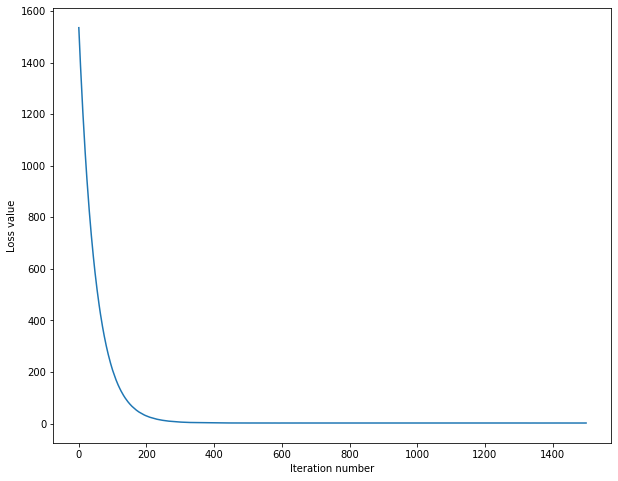

In [59]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [60]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = classifier.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %.2f' % (100*test_accuracy, ))

softmax on raw pixels final test set accuracy: 31.70
